In [14]:
# If this notebook is in a subdirectory of the project's root,
# update the PYTHONPATH to be able to import as usual
import os, sys
project_root = os.path.dirname(os.path.abspath(''))
sys.path.append(project_root)

In [15]:
# Standard Imports
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt

# Project Imports
from train import setup
from utils import save_path
from metrics import calc_herr

In [16]:
hs = np.array([0.8, 0.4, 0.2, 0.1, 0.05])
methods = ['euler-forw', 'euler-symp', 'midpoint']

SAVE_DIR_PREFIX = '/results/experiment-'

In [17]:
# Train all missing models (not recommended on CPU)
# from joblib import Parallel, delayed
# from parallelize import load_args
# from model.args import custom_product
# from train import train_if_missing
# args_list = list(load_args(base_args=default_args, custom_prod=custom_product(h_list=hs, loss_type_list=methods)))
# _ = Parallel(n_jobs=-1, verbose=True)(delayed(train_if_missing)(args, save_dir_prefix='/results/experiment-') for args in args_list)

## Outsource some of the calculations before plotting

In [29]:
def plot_stderr(axes, hs, means, stderrs, label):
    axes.errorbar(hs, means, yerr=stderrs, fmt='o-', label=label)

def plot_quartiles(axes, hs, means, quartiles, label):
    axes.plot(hs, means, 'o-', label=label)
    axes.fill_between(hs, quartiles[:, 0], quartiles[:, 1], alpha=0.25)

plot_fct = plot_quartiles
    
def plot_herr(axes, args, legend_loc='lower right', annotate_slopes=False, clipy=True, omega_m=True, save_dir_prefix=SAVE_DIR_PREFIX):
    # Plot grey guides of y = px, indicating errors of order p 
    axes.loglog(hs, hs, '--', color='grey', linewidth=1)
    axes.loglog(hs, hs**2, '--', color='grey', linewidth=1)
    
    # Plot errors for each method
    for method in methods:
        err = calc_herr(args | {'loss_type': method}, hs, omega_m=omega_m, save_dir_prefix=save_dir_prefix)
        
        # CHOICE: plot_fct as assigned above will result in either of the two results below
        plot_fct(axes, hs, err[:, 0], err[:, 1:], r'$\varepsilon_H$ ' + print_method[method])
        #plot_stderr(axes, hs, err[:, 0], err[:, 1], r'$\varepsilon_H$ ' + print_method[method])
        #plot_quartiles(axes, hs, err[:, 0], err[:, 1:], r'$\varepsilon_H$ ' + print_method[method])
        
        # DEBUGGING:
        # for i, h in enumerate(hs):
        #     print(f"h = {h}, method = {method}: error = {err[i, 0]:.2f} ± {err[i, 1]:.2f}")
    
    # Plot errors for the corrected symplectic Euler
    err = calc_herr(args | {'loss_type': 'euler-symp'}, hs, corrected=True, save_dir_prefix=save_dir_prefix)
    plot_fct(axes, hs, err[:, 0], err[:, 1:], r'$\varepsilon_H$ corrected ' + print_method['euler-symp'])

    # SETUP PLOT META VARIABLES
    axes.set_xlabel("Discretization Step $h$")  # possible kwargs: fontsize=14
    axes.set_ylabel(r"Error $\varepsilon$")  # possible kwargs: rotation=0, fontsize=14
    axes.set_xticks(hs)
    axes.set_xticklabels(map(str, hs))
    axes.set_title(f"{print_name[args.name]}: Hamiltonian Error")  # (fontsize=14) possible kwarg: pad=10 
    
    if clipy:
        axes.set_ylim(.5e-4, 2)
    
    if annotate_slopes: # (fontsize=10)
        # axes.text(0.14, 0.14-0.02, 'O(h)',
        #   color='grey', rotation=15, verticalalignment='bottom', horizontalalignment='center')
        # axes.text(0.15, 0.15**2-0.005, 'O(h^2)',
        #   color='grey', rotation=25, verticalalignment='bottom', horizontalalignment='center')

        axes.text(0.14, 0.14-0.02, r'$\varepsilon \in \mathcal O(h)$',
                  color='grey', rotation=15, verticalalignment='bottom', horizontalalignment='center')
        axes.text(0.15, 0.15**2-0.005, r'$\varepsilon \in \mathcal O(h^2)$',
                  color='grey', rotation=25, verticalalignment='bottom', horizontalalignment='center')
    
    legend = axes.legend(loc=legend_loc)
    legend.get_frame().set_facecolor('0.8')  # fill the legend dark grey
    legend.get_frame().set_linewidth(0.0)  # remove the black border

## Start Plotting Code

In [19]:
# TESTING: One single data point
#from metrics import hamiltonian_error_sampled
#from model.hnn import HNN
#args = default_args | {'name': 'double-pendulum', 'loss_type': 'midpoint', 'h': 0.2}
#args = setup(args, save_dir_prefix='/results/experiment-')
#model, args = HNN.load(args, cpu=True)
#data_loader = args.data_class(args.h, args.noise)
#H_err = np.abs(hamiltonian_error_sampled(model, data_loader, omega_m=True))
#print(np.mean(H_err), np.std(H_err))

In [20]:
# TESTING: The below needs only one method (but all h's) for one problem
#calc_herr(default_args | {'loss_type': 'euler-symp'})
# TESTING: The below needs all methods and all h's of one problem
#fig, axes = plt.subplots() 
#plot_herr(axes, default_args | {'name': 'fput'}, annotate_slopes=True, clipy=False)
# OR
#plot_herr(axes, default_args | {'name': 'pendulum'})

In [21]:

# This does not work
# # from model.args import get_args
# golden_ratio = (5**.5 - 1) / 2
# default_args = get_args(lenient=True) | {'name': 'pendulum'}

In [30]:
import sys
from model.args import get_args

# Simulate command-line argument
sys.argv = ['script_name', 'pendulum']

# Now, this should work without errors
default_args = get_args(lenient=True)


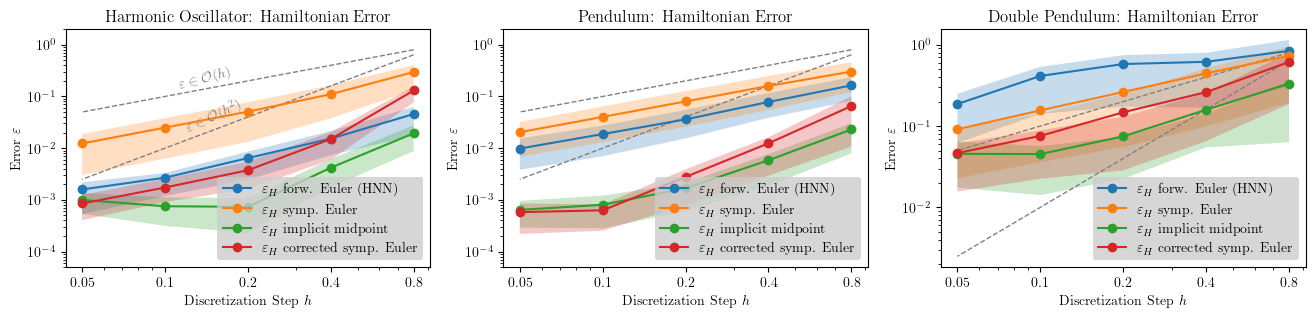

In [31]:
from visualize import print_method
from visualize import print_name
import matplotlib.pyplot as plt

plt.rc('text', usetex=True)
plt.rc('font', family='serif')


golden_ratio = (5**.5 - 1) / 2
# PLOT ALL TOGETHER
fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(16, 5*golden_ratio))
fig.subplots_adjust(wspace=0.2, hspace=0.4)

# plot_herr(ax1, default_args | {'name': 'spring'}, annotate_slopes=True, save_dir_prefix='/results/experiment-')
# plot_herr(ax2, default_args | {'name': 'pendulum'}, save_dir_prefix='/results/experiment-')
# plot_herr(ax3, default_args | {'name': 'double-pendulum'}, clipy=False, save_dir_prefix='/results/experiment-')

plot_herr(ax1, default_args | {'name': 'spring'}, annotate_slopes=True, save_dir_prefix='/experiment-')
plot_herr(ax2, default_args | {'name': 'pendulum'}, save_dir_prefix='/experiment-')
plot_herr(ax3, default_args | {'name': 'double-pendulum'}, clipy=False, save_dir_prefix='/experiment-')


#plot_herr(ax3, default_args | {'name': 'twobody'})
#plot_herr(ax4, default_args | {'name': 'fput'})

#fig.savefig("hamiltonian-error.pdf", format='pdf', bbox_inches='tight')

# Plot the Hamiltonian Error as a Contour Plot

For one specific problem, like the pendulum

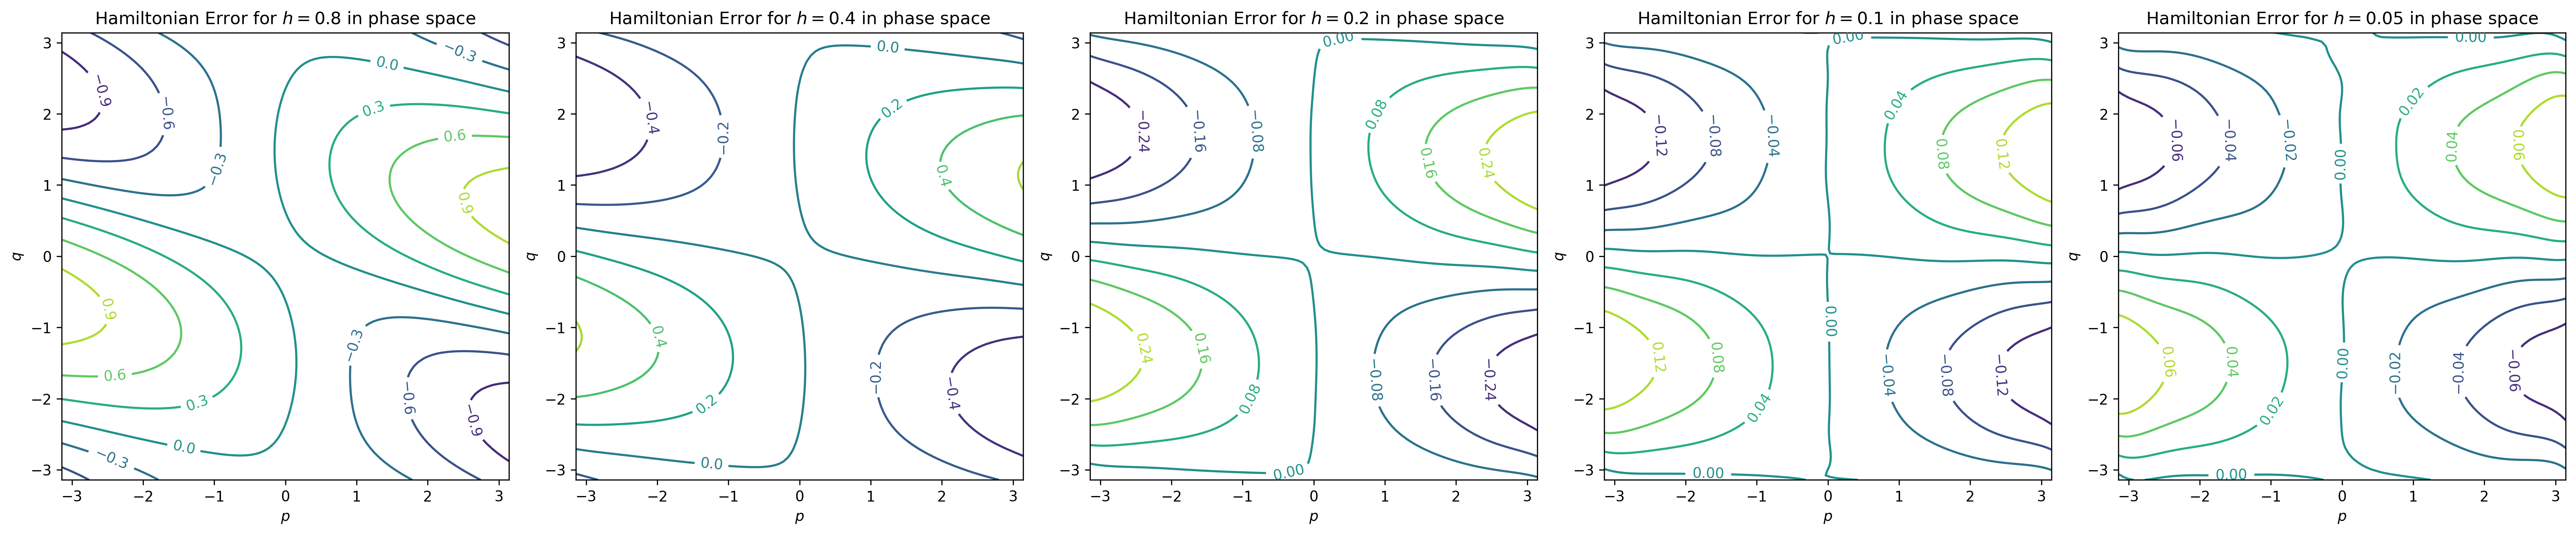

In [24]:
from metrics import load_model, hamiltonian_error_grid
from matplotlib import cm
from scipy.ndimage import gaussian_filter


SAVE_DIR_PREFIX = '/experiment-'

N = len(hs)
fig = plt.figure(figsize=(5*N, 5), facecolor='white', dpi=300)
ax = [fig.add_subplot(1, N, i+1, aspect='equal') for i in range(N)]  # kwarg useful sometimes: aspect='equal'

for i, h in enumerate(hs):
    args = default_args | {'name': 'pendulum', 'loss_type': 'euler-symp', 'h': h}

    # corrected=False is the second argument
    model, args = load_model(args, False, SAVE_DIR_PREFIX)
    data_loader = args.data_class(args.h, args.noise)
    P, Q, H_err = hamiltonian_error_grid(model, data_loader, N=100)

    # smoothed_err = gaussian_filter(H_err, 0.5)
    CS = ax[i].contour(P, Q, H_err)  # cmap=cm.coolwarm as an alternative
    ax[i].set_title(f"Hamiltonian Error for $h={args.h}$ in phase space")
    #ax[i].set_zlim(-1, 1)  # for 3D plots only
    ax[i].clabel(CS, inline=True, fontsize=10)
    ax[i].set_xlabel("$p$")
    ax[i].set_ylabel("$q$")

fig.tight_layout()
plt.savefig(f"hamiltonian-error-contour-{args.name}-{args.loss_type}.pdf", format='pdf', bbox_inches='tight')